# 10X `tcellmatch` Tutorial

This tutorial shows how to preprocess the raw data files from 10x database and feed into a feed forward network for categorical classification. The introduction of 10x can be found here: https://www.10xgenomics.com

The task of this model is based on [this paper](https://www.embopress.org/doi/full/10.15252/msb.20199416), but, in brief, it approximates CDR3 RNA sequences to antigen specificity. This antigen specificity can further be predicted as either number of bindings or max bindings for each sequence.

The architecture of the models are as follows

## BiLSTM

- Input Layer: n x (alpha/beta chain dimension) x CDR3 sequence length x one-hot encoding for each amino acid; here, the shape is `n x 1 x 40 x 26`

- Hidden Layers:
    1. **Embedding Layer**: An optional 1x1 convolutional layer which is used to create lower-dimensional embeddings of one-hot encoded amino acids before the sequence model is applied. The size of the embedding can be configured using the `aa_embedding_dim` parameter.

        Input Shape: (batch_size, sequence_length, aa_embedding_dim)

        Output Shape: (batch_size, sequence_length, embedding_dim)

    2. **Bi-directional Recurrent Layers**: A sequence of BiLSTM or BiGRU layers (configured via the `model` parameter), with a user-specified number of layers and dimensions. These layers process the sequence data and provide capability to capture complex temporal dependencies.

        Input Shape: (batch_size, sequence_length, embedding_dim)

        Output Shape: (batch_size, sequence_length, hidden_size)

    3. **Reshaping Layer**: The output from the BiLSTM/BiGRU layers is reshaped to be 2D in preparation for the fully connected layers, and non-sequence covariates, if provided, are concatenated with the sequence-derived representations.

        Input Shape: (batch_size, sequence_length, hidden_size)

        Output Shape: (batch_size, hidden_size * 2 \[+ hidden_size * 2 if split\] + num_covariates)

    4. **Dense Layers**: A user-specified number of final fully connected layers (`depth_final_dense`) are used for the final task-specific prediction.

        Input Shape: (batch_size, hidden_size * 2 \[+ hidden_size * 2 if split\] + num_covariates)

        Output Shape: (batch_size, labels_dim)


- Activation: ReLU or Softmax depending on task

## Self-Attention

- Input Layer: n x (alpha/beta chain dimension) x CDR3 sequence length x one-hot encoding for each amino acid; here, the shape is ``n x 1 x 40 x 26``
- Hidden Layers:
    1. **Embedding Layer**: An optional 1x1 convolutional layer which is used to create lower-dimensional embeddings of one-hot encoded amino acids before the sequence model is applied. The size of the embedding can be configured using the `aa_embedding_dim` parameter.

        Input Shape: (batch_size, sequence_length, aa_embedding_dim)

        Output Shape: (batch_size, sequence_length, attention_size)

    2. **Reshaping Layer**: The output from the self-attention layers is reshaped to be 2D in preparation for the fully connected layers, and non-sequence covariates, if provided, are concatenated with the sequence-derived representations

        Input Shape: (batch_size, sequence_length, attention_size)

        Output Shape: (batch_size, sequence_length * attention_size + num_covariates)
    3. **Dense Layers**: A user-specified number of final fully connected layers (`depth_final_dense`) are used for the final task-specific prediction. 

        Input Shape: (batch_size, sequence_length * attention_size + num_covariates)

        Output Shape: (batch_size, labels_dim)

- Activation: ReLU or Softmax depending on task


In [1]:
import pandas as pd
import tcellmatch.api as tm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_model_summary import summary
from torchmetrics import Accuracy
import torch
import os
import numpy as np

# Get Data Directories

You can find the data below:

https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-1-1-standard-3-0-2

https://www.10xgenomics.com/resources/datasets/cd-8-plus-t-cells-of-healthy-donor-2-1-standard-3-0-2

For each donor, the binarized matrix corresponds to "binarized matrix CSV" on 10X and the clonotype matrix corresponds to "VDJ - Clonotype info (CSV)"

In [2]:
# Path of input directory.
indir = '../tutorial_data/'
# Path to 10x raw files.
fns = [f"{indir}vdj_v1_hs_aggregated_donor1_binarized_matrix.csv",
       f"{indir}vdj_v1_hs_aggregated_donor2_binarized_matrix.csv"]
# Path to preprocessed clonotypes files.
fns_clonotype = [f"{indir}vdj_v1_hs_aggregated_donor1_clonotypes.csv",
                 f"{indir}vdj_v1_hs_aggregated_donor2_clonotypes.csv"]

In [3]:
cellranger_out = pd.read_csv(fns[0])
cellranger_out.head()

,barcode,donor,cell_clono_cdr3_aa,cell_clono_cdr3_nt,CD3,CD19,CD45RA,CD4,CD8a,CD14,...,B0702_RPHERNGFTVL_pp65_CMV_binder,B0801_RAKFKQLL_BZLF1_EBV_binder,B0801_ELRRKMMYM_IE-1_CMV_binder,B0801_FLRGRAYGL_EBNA-3A_EBV_binder,A0101_SLEGGGLGY_NC_binder,A0101_STEGGGLAY_NC_binder,A0201_ALIAPVHAV_NC_binder,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder
0,AAACCTGAGACAAAGG-4,donor1,TRA:CAASVSIWTGTASKLTF;TRA:CAAWDMEYGNKLVF;TRB:C...,TRA:TGTGCAGCAAGCGTTAGTATTTGGACCGGCACTGCCAGTAAA...,2125.0,0.0,912.0,1.0,2223.0,4.0,...,False,False,False,False,False,False,False,False,False,False
1,AAACCTGAGACTGTAA-34,donor1,TRB:CASDTPVGQFF,TRB:TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,1023.0,0.0,2028.0,2.0,3485.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,AAACCTGAGAGCCCAA-5,donor1,TRA:CASYTDKLIF;TRB:CASSGGSISTDTQYF,TRA:TGTGCTTCCTACACCGACAAGCTCATCTTT;TRB:TGCGCCA...,1598.0,3.0,3454.0,4.0,3383.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,AAACCTGAGAGCTGCA-24,donor1,TRB:CASSGGQSSYEQYF,TRB:TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,298.0,1.0,880.0,1.0,2389.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,AAACCTGAGAGGGATA-8,donor1,TRA:CAASGYGNTGRRALTF;TRB:CASSQDPAGGYNEQFF,TRA:TGTGCAGCAAGCGGGTATGGAAACACGGGCAGGAGAGCACTT...,1036.0,0.0,2457.0,2.0,3427.0,3.0,...,False,False,False,False,False,False,False,False,False,False


In [4]:
data = cellranger_out
column_names = data.columns
column_types = data.dtypes

In [5]:
cellranger_out = pd.read_csv(fns_clonotype[0])
cellranger_out.head()

,clonotype_id,frequency,proportion,cdr3s_aa,cdr3s_nt
0,clonotype1,2407,0.050583,TRA:CAGHTGNQFYF;TRB:CASSWGGGSHYGYTF,TRA:TGTGCTGGTCACACCGGTAACCAGTTCTATTTT;TRB:TGTG...
1,clonotype2,1244,0.026143,TRA:CAARVRGFGNVLHC;TRA:CAVGDNFNKFYF;TRB:CASSLY...,TRA:TGTGCAGCAAGAGTGCGGGGCTTTGGGAATGTGCTGCATTGC...
2,clonotype3,1167,0.024525,TRB:CASSWGGGSHYGYTF,TRB:TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC
3,clonotype4,512,0.010760,TRA:CAVSAASGGSYIPTF;TRB:CASSPRDRERGEQYF,TRA:TGTGCTGTGAGTGCAGCATCAGGAGGAAGCTACATACCTACA...
4,clonotype5,419,0.008805,TRA:CAMNPAWGGATNKLIF;TRB:CSASPGDYEQYF,TRA:TGTGCAATGAACCCGGCGTGGGGTGGTGCTACAAACAAGCTC...


## List of column names of labels to predict in 10x raw files
Here we take all antigens from 10x dataset for prediction

In [6]:
target_ids = [
    'A0101_VTEHDTLLY_IE-1_CMV_binder',
    'A0201_KTWGQYWQV_gp100_Cancer_binder',
    'A0201_ELAGIGILTV_MART-1_Cancer_binder',
    'A0201_CLLWSFQTSA_Tyrosinase_Cancer_binder',
    'A0201_IMDQVPFSV_gp100_Cancer_binder',
    'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder',
    'A0201_KVAELVHFL_MAGE-A3_Cancer_binder',
    'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder',
    'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder',
    'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder',
    'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder',
    'A0201_CLGGLLTMV_LMP-2A_EBV_binder',
    'A0201_YLLEMLWRL_LMP1_EBV_binder',
    'A0201_FLYALALLL_LMP2A_EBV_binder',
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0201_GLCTLVAML_BMLF1_EBV_binder',
    'A0201_NLVPMVATV_pp65_CMV_binder',
    'A0201_ILKEPVHGV_RT_HIV_binder',
    'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder',
    'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder',
    'A0201_RTLNAWVKV_Gag-protein_HIV_binder',
    'A0201_KLQCVDLHV_PSA146-154_binder',
    'A0201_LLFGYPVYV_HTLV-1_binder',
    'A0201_SLFNTVATL_Gag-protein_HIV_binder',
    'A0201_SLYNTVATLY_Gag-protein_HIV_binder',
    'A0201_SLFNTVATLY_Gag-protein_HIV_binder',
    'A0201_RMFPNAPYL_WT-1_binder',
    'A0201_YLNDHLEPWI_BCL-X_Cancer_binder',
    'A0201_MLDLQPETT_16E7_HPV_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
    'A0301_RIAAWMATY_BCL-2L1_Cancer_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
    'B3501_IPSINVHHY_pp65_CMV_binder',
    'A2402_AYAQKIFKI_IE-1_CMV_binder',
    'A2402_QYDPVAALF_pp65_CMV_binder',
    'B0702_QPRAPIRPI_EBNA-6_EBV_binder',
    'B0702_TPRVTGGGAM_pp65_CMV_binder',
    'B0702_RPPIFIRRL_EBNA-3A_EBV_binder',
    'B0702_RPHERNGFTVL_pp65_CMV_binder',
    'B0801_RAKFKQLL_BZLF1_EBV_binder',
    'B0801_ELRRKMMYM_IE-1_CMV_binder',
    'B0801_FLRGRAYGL_EBNA-3A_EBV_binder',
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

## List of column names of negative controls in 10x raw files

In [7]:
nc_cols = [
    'A0101_SLEGGGLGY_NC_binder',
    'A0101_STEGGGLAY_NC_binder',
    'A0201_ALIAPVHAV_NC_binder',
    'A2402_AYSSAGASI_NC_binder',
    'B0702_GPAESAAGL_NC_binder',
    'NR(B0801)_AAKGRGAAL_NC_binder'
]

### (Optional) Use these if you want binding counts instead of top binder categorical

In [8]:
USE_BIND_COUNTS = True

if USE_BIND_COUNTS:
    target_ids = [
        'A0101_VTEHDTLLY_IE-1_CMV',
        'A0201_KTWGQYWQV_gp100_Cancer',
        'A0201_ELAGIGILTV_MART-1_Cancer',
        'A0201_CLLWSFQTSA_Tyrosinase_Cancer',
        'A0201_IMDQVPFSV_gp100_Cancer',
        'A0201_SLLMWITQV_NY-ESO-1_Cancer',
        'A0201_KVAELVHFL_MAGE-A3_Cancer',
        'A0201_KVLEYVIKV_MAGE-A1_Cancer',
        'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase',
        'A0201_LLDFVRFMGV_EBNA-3B_EBV',
        'A0201_LLMGTLGIVC_HPV-16E7_82-91',
        'A0201_CLGGLLTMV_LMP-2A_EBV',
        'A0201_YLLEMLWRL_LMP1_EBV',
        'A0201_FLYALALLL_LMP2A_EBV',
        'A0201_GILGFVFTL_Flu-MP_Influenza',
        'A0201_GLCTLVAML_BMLF1_EBV',
        'A0201_NLVPMVATV_pp65_CMV',
        'A0201_ILKEPVHGV_RT_HIV',
        'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2',
        'A2402_CYTWNQMNL_WT1-(235-243)236M_Y',
        'A0201_RTLNAWVKV_Gag-protein_HIV',
        'A0201_KLQCVDLHV_PSA146-154',
        'A0201_LLFGYPVYV_HTLV-1',
        'A0201_SLFNTVATL_Gag-protein_HIV',
        'A0201_SLYNTVATLY_Gag-protein_HIV',
        'A0201_SLFNTVATLY_Gag-protein_HIV',
        'A0201_RMFPNAPYL_WT-1',
        'A0201_YLNDHLEPWI_BCL-X_Cancer',
        'A0201_MLDLQPETT_16E7_HPV',
        'A0301_KLGGALQAK_IE-1_CMV',
        'A0301_RLRAEAQVK_EMNA-3A_EBV',
        'A0301_RIAAWMATY_BCL-2L1_Cancer',
        'A1101_IVTDFSVIK_EBNA-3B_EBV',
        'A1101_AVFDRKSDAK_EBNA-3B_EBV',
        'B3501_IPSINVHHY_pp65_CMV',
        'A2402_AYAQKIFKI_IE-1_CMV',
        'A2402_QYDPVAALF_pp65_CMV',
        'B0702_QPRAPIRPI_EBNA-6_EBV',
        'B0702_TPRVTGGGAM_pp65_CMV',
        'B0702_RPPIFIRRL_EBNA-3A_EBV',
        'B0702_RPHERNGFTVL_pp65_CMV',
        'B0801_RAKFKQLL_BZLF1_EBV',
        'B0801_ELRRKMMYM_IE-1_CMV',
        'B0801_FLRGRAYGL_EBNA-3A_EBV',
        'A0101_SLEGGGLGY_NC',
        'A0101_STEGGGLAY_NC',
        'A0201_ALIAPVHAV_NC',
        'A2402_AYSSAGASI_NC',
        'B0702_GPAESAAGL_NC',
        'NR(B0801)_AAKGRGAAL_NC',
    ]
    nc_cols = [
        'A0101_SLEGGGLGY_NC',
        'A0101_STEGGGLAY_NC',
        'A0201_ALIAPVHAV_NC',
        'A2402_AYSSAGASI_NC',
        'B0702_GPAESAAGL_NC',
        'NR(B0801)_AAKGRGAAL_NC'
    ]

# Read data

## Create model object
EstimatorFfn() includes all of reading, training and testing modules.

In [9]:
ffn = tm.models.EstimatorFfn()

## Read 10x raw files, taking out TCR CDR3 and binarized binding matrix as training data
We encode the TCR CDR3 amino acid sequences (include TRA and TRB) with one-hot encoding, the embedded sequences are of shape [num_samples, tra/trb, max_sequence_length, aa_onehot_dim]. For example if we take out 4000 TRB sequences seperately, the maximal length of sequences is 30 and we have 22 amino acids, the shape of output would be [4000, 1, 30, 26]. 

In [10]:
ffn.read_binarized_matrix(
    fns=[indir + x for x in fns],
    fns_clonotype=[indir + x for x in fns_clonotype],
    fns_covar=[],
    fn_blosum=f"{indir}BLOSUM50.csv",
    blosum_encoding=False,
    is_train=True,
    # include categorical variable for which donor we get from
    covariate_formula_categ=["donor"],
    covariate_formula_numeric=[],
    # Whether to add an additional non-binder category for softmax activation function
    add_non_binder_for_softmax=False,
    # we are only keeping trb chain
    chains="trb",
    label_cols=target_ids,
    nc_cols=nc_cols
)

Found 29618 clonotypes for 46526 observations in single file.
Found 19318 clonotypes for 77854 observations in single file.
Found 40500 clonotypes for 109637 observations and assigned to train data.


In [11]:
sums_across_last_dim = np.sum(ffn.x_train, axis=-1)

# Find rows which are not "zero-hot"
non_zero_hot_rows = np.any(sums_across_last_dim > 0, axis=-1)

ffn.x_train = ffn.x_train[non_zero_hot_rows]

In [12]:
# valid idxs along the first dimension
valid_idxs = non_zero_hot_rows[:, 0, 0]
ffn.clone_train = ffn.clone_train[valid_idxs]
ffn.covariates_train = ffn.covariates_train[valid_idxs]
ffn.y_train = ffn.y_train[valid_idxs]

ffn.x_train = ffn.x_train[:, np.newaxis, :]

The input consists of TCR CDR3 sequences and covariates. Covariates act as a additional information which will be concatenated with TCR CDR3 sequences during training. The target set is a binarized matrix which shows the binding between TCR CDR3 and antigens.

In [13]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
# print("The head of TCR sequences: ",ffn.x_train[0])
print("Shape of covariates: ",ffn.covariates_train.shape)
# print("The head of covariates: ",ffn.covariates_train[0:5])
print("Shape of target set: ",ffn.y_train.shape)
# print("The head of target set: ",ffn.y_train[0:5])

Shape of TCR sequences:  (106664, 1, 27, 26)
Shape of covariates:  (106664, 2)
Shape of target set:  (106664, 50)


Some of these sequences are not one-hot, but "zero-hot" encoded. We remove those

## Downsample clonotypes to data stored in x_train
This avoids training, evaluation or test set being too biased toward a subset of TCRs.

In [14]:
# max_obs: Maximum number of observations per clonotype.
ffn.downsample_clonotype(max_obs=10)

Downsampled 38869 clonotypes from 106664 cells to 54471 cells.


In [15]:
print("Shape of TCR sequences: ",ffn.x_train.shape)
print("Shape of covariates: ",ffn.covariates_train.shape)
print("Shape of target set: ",ffn.y_train.shape)

Shape of TCR sequences:  (54471, 1, 27, 26)
Shape of covariates:  (54471, 2)
Shape of target set:  (54471, 50)


## Create test dataset
We can either split the training set or use a new database as the test set. Here, we split test set from training set.

In [16]:
ffn.clear_test_data()
ffn.sample_test_set(test_split=0.1)

Number of observations in test data: 5428
Number of observations in training+evaluation data: 49043


In [17]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of covariates for training: ",ffn.covariates_train.shape)
print("Shape of target set for training: ",ffn.y_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)
print("Shape of covariates for test: ",ffn.covariates_test.shape)
print("Shape of target set for test: ",ffn.y_test.shape)

Shape of TCR CDR3 sequences for training:  (49043, 1, 27, 26)
Shape of covariates for training:  (49043, 2)
Shape of target set for training:  (49043, 50)
Shape of TCR CDR3 sequences for test:  (5428, 1, 27, 26)
Shape of covariates for test:  (5428, 2)
Shape of target set for test:  (5428, 50)


## Padding TCR CDR3 sequences in both training and testing set
Since we can use TCR CDR3 in another database as the test set, we should make sure they have same size.

In [18]:
ffn.pad_sequence(target_len=40, sequence="tcr")

## Downsample data to given number of observations.
In order to save time, we sample a small dataset for training. Never use this method in practice. 

In [19]:
ffn.downsample_data(n=200, data="train")
ffn.downsample_data(n=200, data="test")

Downsampled train data from 49043 cells to 200 cells.
Downsampled test data from 5428 cells to 200 cells.


In [20]:
print("Shape of TCR CDR3 sequences for training: ",ffn.x_train.shape)
print("Shape of TCR CDR3 sequences for test: ",ffn.x_test.shape)

Shape of TCR CDR3 sequences for training:  (200, 1, 40, 26)
Shape of TCR CDR3 sequences for test:  (200, 1, 40, 26)


### Save imported data as NumPy Arrays (optional)
This can be useful if you want to avoid binarizing when debugging the model

In [21]:
# SAVE_TO_NUMPY = True
# if SAVE_TO_NUMPY:
#     np.savez_compressed(
#         f"{indir}ffn_data_downsampled.npz",
#         x_train=ffn.x_train,
#         covariates_train=ffn.covariates_train,
#         y_train=ffn.y_train,
#         x_test=ffn.x_test,
#         covariates_test=ffn.covariates_test,
#         y_test=ffn.y_test,
#         clone_train=ffn.clone_train
#     )

# Build Model
Here, we can build two models: a BiLSTM-based or self-attention-based model, detailed above.

Loss has the following possible parameters

1. Discrete
    1. Binary Crossentropy (param "bce")
    2. Weighted Binary Crossentropy (param "wbce")
    3. Categorical Crossentropy (param "cce")
2. Continuous
    1. MMD (param "mmd")
    2. Mean Squared error (param "mse")
    3. Poisson (param "pois")
    
Calling one of these creates the model and sets the ffn.model attribute.

In [22]:
model_name = 'CNN'

In [24]:
if model_name.lower() == 'self-attention':
    ffn.build_self_attention(
        residual_connection=True,
        aa_embedding_dim=0,
        # hidden size of each attention layer
        attention_size=[5, 5],
        # number of heads at each layer
        attention_heads=[4, 4],
        optimizer='adam',
        lr=0.001,
        loss='mmd' if USE_BIND_COUNTS else 'wbce',
        label_smoothing=0
    )
elif model_name.lower() == 'bilstm':
    ffn.build_bilstm(
        # The depth of each bilstm layer (length of feature vector)
        topology = [10, 10, 10, 10],
        residual_connection=True,
        # Dimension of the linear amino acid embedding, ie number of 1x1 convolutional filters.
        # set to input dimension if aa_embedding_dim==0.
        aa_embedding_dim=0,
        optimizer='adam',
        lr=0.001,
        loss='pois' if USE_BIND_COUNTS else 'wcbe',
        label_smoothing=0,
        # whether to assume covariates in model architecture
        use_covariates=False,
        # whether we are predicting max binding categorical
        # or binding counts
        one_hot_y=not USE_BIND_COUNTS
    )
elif model_name.lower() == 'bigru':
    ffn.build_bigru(
        topology=[10, 10, 10],
        aa_embedding_dim=0,
        residual_connection=True,
        lr=0.005,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
        optimize_for_gpu= True,
    )
elif model_name.lower() == 'cnn':
    ffn.build_conv(
        n_conv_layers = 3,
        depth_final_dense = 3,
        filter_widths = [3, 5, 3],  # Filter widths for the three convolutional layers
        filters = [16, 32, 64],  # Output channels for the three convolutional layers
        pool_sizes = (2, 2),  # Size of the pooling window
        pool_strides = (2, 2),  # Stride for moving the pooling window,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
    )

pool params: size 2 stride 2
pool params: size 2 stride 2


# Train model
Train this model for 2 epochs     

In [25]:
EPOCHS = 2
train_curve, val_curve = ffn.train(
    epochs=EPOCHS,
    batch_size=8,
    # tensorboard logs to this directory
    log_dir='training_runs',
    # if true, saves epochs x n_classes as ffn.antigen_loss
    # ijth element is loss of ith epoch on jth antigen
    save_antigen_loss=False,
    allow_early_stopping=True
    )

Number of observations in evaluation data: 20
Number of observations in training data: 180


### Plot Loss Curves

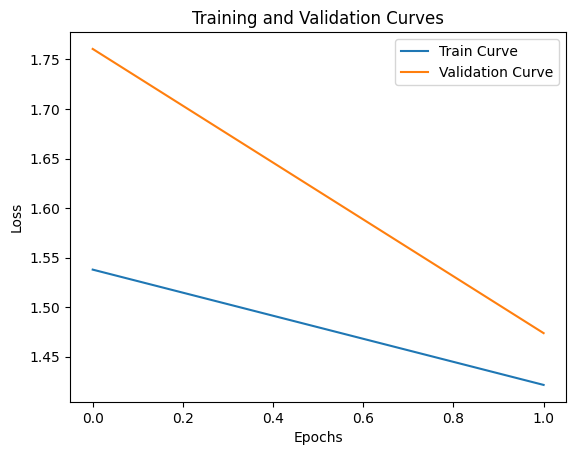

In [26]:
# Plotting the curves
plt.plot(train_curve, label='Train Curve')
plt.plot(val_curve, label='Validation Curve')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

## Get embeddings

Use this function to get the ouputs before our linear layer and store them for other use.

In [27]:
pred = ffn.model.get_embeddings(torch.ones(1, 1, 40, 26))

# Use model

## Evaluate on test set
This evaluates the data and returns binary and custom (i.e., based on how the model was built above) loss metrics

In [28]:
ffn.evaluate(
    # given k, returns loss only over the kth antigen in test
    antigen_col=None
)

{'test': {PoissonNLLLoss(): 1.8240456581115723, 'Binary Accuracy': 43.45}}

## Save the model

In [29]:
os.makedirs(f'{indir}saved_model', exist_ok=True)
# save_yhat means save predictions
ffn.save_model_full(f'{indir}saved_model', save_yhat=True, save_train_data=False)

# Evaluate/Compare the Model
We predict the labels on test data and store to `ffn.predictions`

In [30]:
ffn.predict()
ffn.predictions.shape

(200, 50)

### Create Confusion Matrix
This is only applicable, of course, if you've used the one-hot encoded maximum binding y-data. If it is, you can use this to also compare with the original tcellmatch in torch

In [31]:
if not USE_BIND_COUNTS:
    true_labels = np.argmax(ffn.y_test, axis=1)
    predicted_labels = np.argmax(ffn.predictions, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Reproduce evaluation in a new instance of model w/ same weights

We load the model, with weights and data included, and evaluate and predict on the test data

In [32]:
ffn2 = tm.models.EstimatorFfn()
ffn2.load_model_full(fn=f'{indir}saved_model', load_train_data=False)
print(ffn2.evaluate(test_only=True))
ffn2.predict()

pool params: size 2 stride 2
pool params: size 2 stride 2
{'test': {PoissonNLLLoss(): 1.8240456581115723, 'Binary Accuracy': 43.45}}


## Plot Residuals
This function outputs a MatPlotLib histogram of the residuals of the given antigen index (here `0`) over the test data. `predict()` must be called first to generate our test predictions.

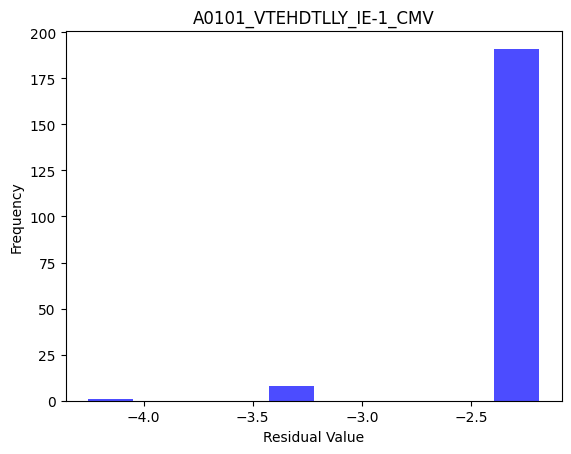

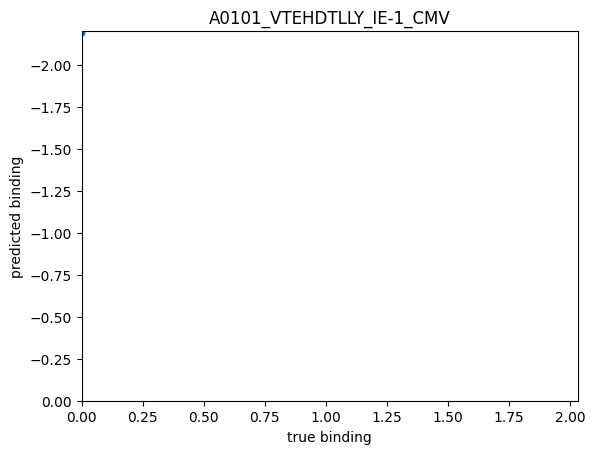

In [33]:
ffn.plot_residuals(antigen_idx=0, target_ids=target_ids)
ffn.compare_preds(antigen_idx=0, target_ids=target_ids)